Setup

In [31]:
from pathlib import Path

ROOT = Path.cwd()
while ROOT != ROOT.parent and not ((ROOT / "src").exists() and (ROOT / "results").exists()):
    ROOT = ROOT.parent

print("[ROOT]", ROOT)
METRICS = ROOT / "results" / "metrics"
MODELS  = ROOT / "results" / "models"
PROC    = ROOT / "data" / "processed"


[ROOT] c:\PROJECT_IOT_IDS


In [33]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

# Locate project root (folder that has /src and /results)
ROOT = Path.cwd()
while ROOT != ROOT.parent and not ((ROOT / "src").exists() and (ROOT / "results").exists()):
    ROOT = ROOT.parent
print("[ROOT]", ROOT)

METRICS = ROOT / "results" / "metrics"
VIZ     = ROOT / "results" / "figures" / "viz"
VIZ.mkdir(parents=True, exist_ok=True)

PREFIX = "supervised_binary_baseline"  # ← you said everything is saved under this prefix

def save_fig(name, dpi=160):
    out = VIZ / name
    plt.tight_layout()
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    print("[SAVED]", out)


[ROOT] c:\PROJECT_IOT_IDS


1) Binary — Confusion Matrices (counts & normalized), Per-class F1

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\binary_cm_heatmap.png


<Figure size 600x500 with 0 Axes>

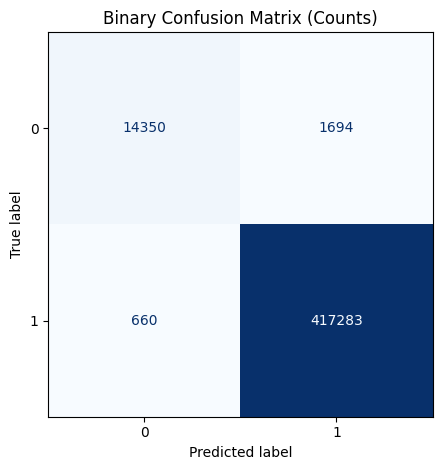

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\binary_cm_heatmap_norm.png


<Figure size 600x500 with 0 Axes>

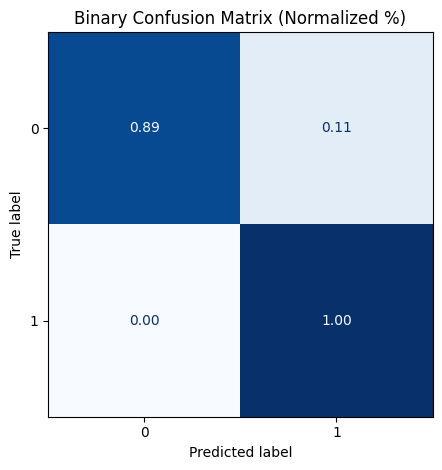

In [34]:
# Prefer raw arrays if present; otherwise fall back to cm/report CSVs.
y_test_np   = METRICS / f"{PREFIX}_y_test.npy"
y_pred_np   = METRICS / f"{PREFIX}_y_pred.npy"
report_csv  = METRICS / f"{PREFIX}_report.csv"
cm_csv      = METRICS / f"{PREFIX}_cm.csv"

if y_test_np.exists() and y_pred_np.exists():
    y_true = np.load(y_test_np, allow_pickle=True)
    y_pred = np.load(y_pred_np, allow_pickle=True)
    labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
else:
    # Counts CM from CSV
    rep = pd.read_csv(report_csv, index_col=0) if report_csv.exists() else None
    cm_df = pd.read_csv(cm_csv, index_col=0)
    labels = cm_df.index.tolist()
    cm = cm_df.values

# Counts heatmap
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(cm, display_labels=labels).plot(values_format=".0f", cmap="Blues", colorbar=False)
plt.title("Binary Confusion Matrix (Counts)")
plt.xticks(rotation=0)
save_fig("binary_cm_heatmap.png")
plt.show()

# Normalized-by-row heatmap
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay(cm_norm, display_labels=labels).plot(values_format=".2f", cmap="Blues", colorbar=False)
plt.title("Binary Confusion Matrix (Normalized %)")
plt.xticks(rotation=0)
save_fig("binary_cm_heatmap_norm.png")
plt.show()



Counts CM shows total mistakes; normalized CM shows recall per true class (diagonal).

If Benign→Attack is high, reduce false positives (threshold, class weights). If Attack→Benign is high, increase sensitivity.

Per-class F1 highlights the weaker class to target for improvement.

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\binary_f1.png


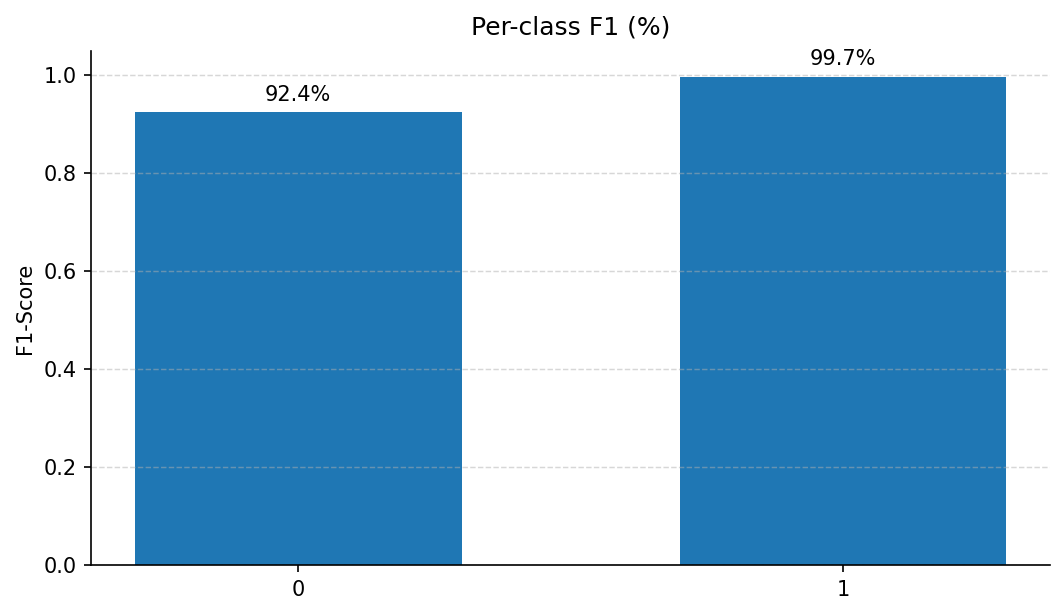

In [35]:
# per-class F1 from supervised_binary_baseline CSV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rep = pd.read_csv(report_csv, index_col=0)  # keep your path var

def _extract_f1_series(df: pd.DataFrame) -> pd.Series:
    """Return a numeric Series of per-class F1 from a classification_report CSV,
    regardless of whether F1 is in columns or rows. Excludes avg/accuracy."""
    df = df.copy()
    df.index = [str(i).strip() for i in df.index]
    df.columns = [str(c).strip() for c in df.columns]

    # case A: columns contain f1-score
    col_match = [c for c in df.columns
                 if c.lower().replace(" ", "").replace("_","") in ("f1-score","f1score","f1")]
    if col_match:
        s = df[col_match[0]]
        keep_rows = [i for i in df.index
                     if "avg" not in i.lower() and "accuracy" not in i.lower()]
        s = s.loc[keep_rows]
        s = pd.to_numeric(s, errors="coerce").dropna()
        return s

    # case B: rows contain f1-score
    row_match = [i for i in df.index
                 if str(i).lower().replace(" ", "").replace("_","") in ("f1-score","f1score","f1")]
    if row_match:
        s = df.loc[row_match[0]]
        keep_cols = [c for c in df.columns
                     if "avg" not in c.lower() and "accuracy" not in c.lower() and "support" not in c.lower()]
        s = s.loc[keep_cols]
        s = pd.to_numeric(s, errors="coerce").dropna()
        return s

    raise ValueError("Could not find 'f1-score' in the report CSV.")

f1_series = _extract_f1_series(rep)

# ---- plot ----
fig, ax = plt.subplots(figsize=(7.2, 4.2), dpi=150)
x = np.arange(len(f1_series))
bars = ax.bar(x, f1_series.values, width=0.6)

ax.set_xticks(x)
ax.set_xticklabels(f1_series.index, rotation=0)
ax.set_ylim(0, 1.05)
ax.set_ylabel("F1-Score")
ax.set_title("Per-class F1 (%)", pad=8, fontsize=12)

# subtle style
ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# % labels on top of bars
for r in bars:
    h = r.get_height()
    ax.text(r.get_x() + r.get_width()/2, h + 0.015, f"{h:.1%}",
            ha="center", va="bottom", fontsize=10)

plt.tight_layout()
save_fig("binary_f1.png")
plt.show()


2) Precision–Recall & ROC

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\binary_pr.png


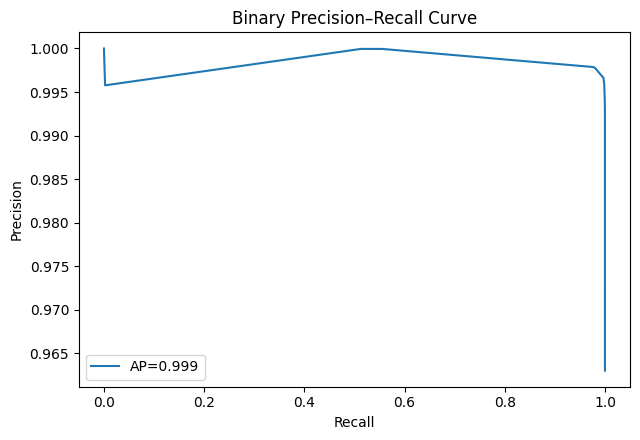

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\binary_roc.png


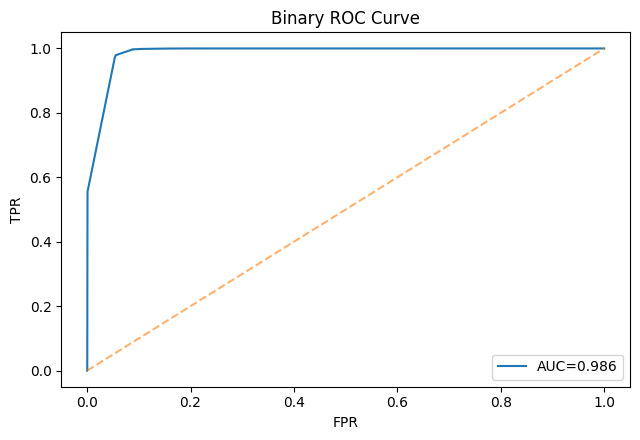

In [36]:
scores_np = METRICS / f"{PREFIX}_y_scores.npy"
if scores_np.exists() and (METRICS / f"{PREFIX}_y_test.npy").exists():
    y_true = np.load(METRICS / f"{PREFIX}_y_test.npy", allow_pickle=True).astype(int)
    y_scores = np.load(scores_np, allow_pickle=True)
    # If scores are (n,2), use positive-class column
    if y_scores.ndim == 2 and y_scores.shape[1] == 2:
        y_scores = y_scores[:, 1]

    # PR curve
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    plt.figure(figsize=(6.5,4.5))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Binary Precision–Recall Curve"); plt.legend()
    save_fig("binary_pr.png")
    plt.show()

    # ROC curve
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(6.5,4.5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1], linestyle="--", alpha=0.6)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Binary ROC Curve"); plt.legend()
    save_fig("binary_roc.png")
    plt.show()
else:
    print("[SKIP] No scores found for PR/ROC. Re-train saving probabilities if needed.")


PR curve is best under imbalance; pick an operating point balancing recall (catching attacks) and precision (alert load).

ROC AUC near 1.0 indicates good separability; read alongside PR to avoid optimism under skewed data.

Multiclass — Confusion matrices

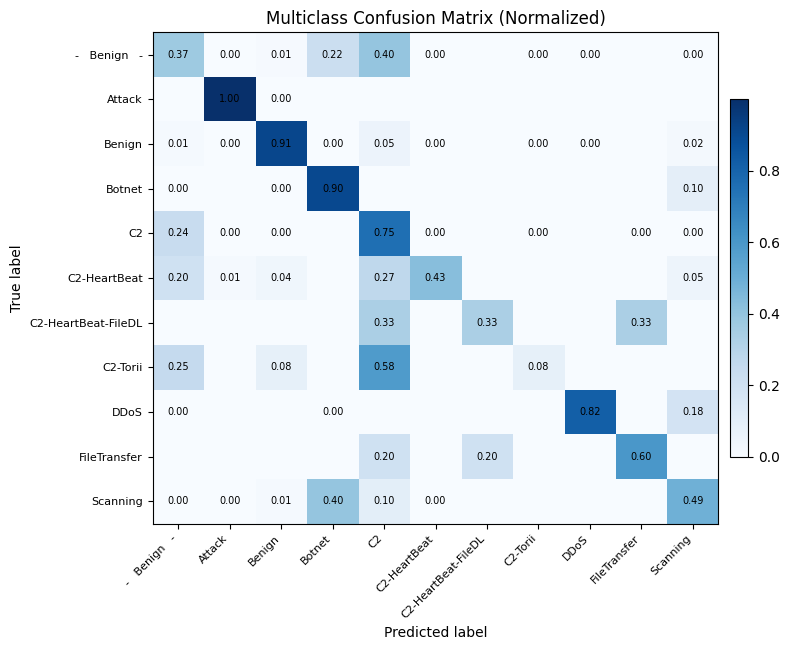

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\multiclass_cm_heatmap_norm.png


In [37]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---- locate your artifacts ----
ROOT = Path.cwd()
while ROOT != ROOT.parent and not ((ROOT / "src").exists() and (ROOT / "results").exists()):
    ROOT = ROOT.parent
METRICS = ROOT / "results" / "metrics"
VIZ = ROOT / "results" / "figures" / "viz"; VIZ.mkdir(parents=True, exist_ok=True)

PREFIX_MC = "supervised_multiclass_baseline"
y_test_np = METRICS / f"{PREFIX_MC}_y_test.npy"
y_pred_np = METRICS / f"{PREFIX_MC}_y_pred.npy"
cm_csv    = METRICS / f"{PREFIX_MC}_cm.csv"

# ---- load cm + labels robustly ----
if y_test_np.exists() and y_pred_np.exists():
    y_true = np.load(y_test_np, allow_pickle=True)
    y_pred = np.load(y_pred_np, allow_pickle=True)
    labels = sorted(pd.unique(np.concatenate([y_true, y_pred])))
    cm     = confusion_matrix(y_true, y_pred, labels=labels)
else:
    cm_df  = pd.read_csv(cm_csv, index_col=0)
    labels = cm_df.index.tolist()
    cm     = cm_df.values

# ---- tidy labels (shorten long ones without changing order) ----
def pretty(lbl: str) -> str:
    s = str(lbl)
    s = s.replace("C&C", "C2")            # common short form
    s = s.replace("FileDownload", "FileDL")
    s = s.replace("PartOfAHorizontalPortScan", "HorizScan")
    return s

labels_pretty = [pretty(x) for x in labels]

# ---- dynamic figure size based on number of classes ----
n = len(labels_pretty)
w = max(8, min(0.6*n, 20))   # width grows with classes (cap at 20")
h = max(6, min(0.6*n, 20))   # height grows with classes (cap at 20")

# ---- normalized matrix (row-wise) ----
cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(w, h))
im = plt.imshow(cm_norm, aspect='auto', interpolation='nearest', cmap='Blues')
plt.colorbar(im, fraction=0.03, pad=0.02)
plt.title("Multiclass Confusion Matrix (Normalized)")

# ticks & fonts
plt.xticks(range(n), labels_pretty, rotation=45, ha='right', fontsize=8)
plt.yticks(range(n), labels_pretty, fontsize=8)

# annotate ONLY if class count is small enough
if n <= 15:
    for i in range(n):
        for j in range(n):
            val = cm_norm[i, j]
            if val > 0:
                plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=7)

plt.xlabel("Predicted label"); plt.ylabel("True label")
plt.tight_layout()
out = VIZ / "multiclass_cm_heatmap_norm.png"
plt.savefig(out, dpi=200)
plt.show()
print("[SAVED]", out)


Class distribution in the test set

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\multiclass_test_distribution.png


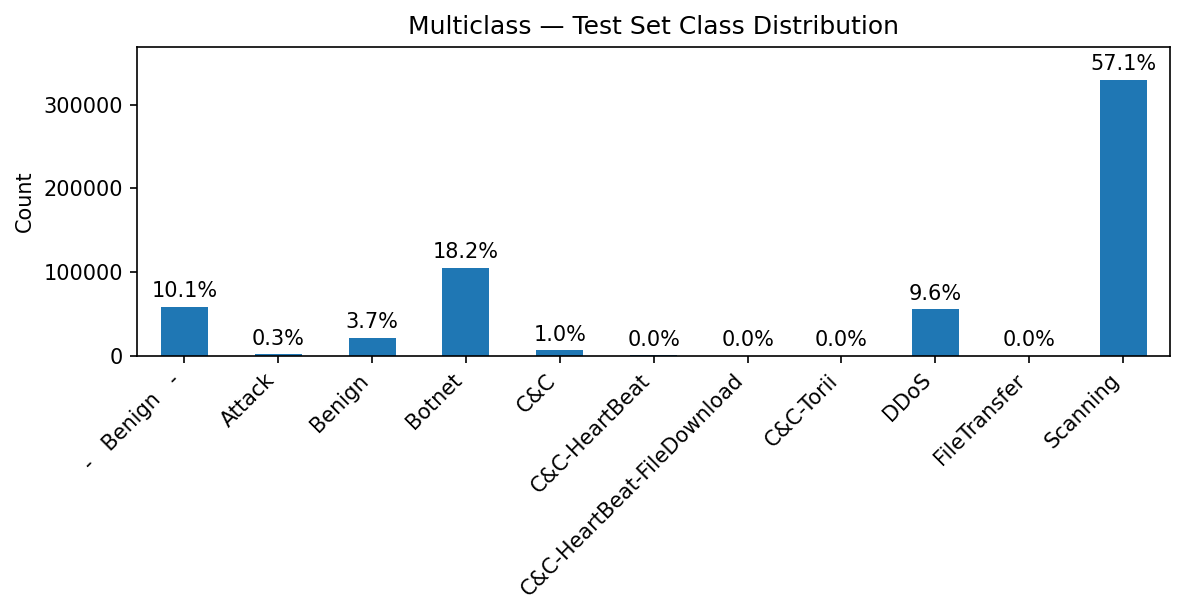

In [38]:
# Load true labels (fallback to CM labels if arrays are missing)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

y_test_np  = METRICS / f"{PREFIX_MC}_y_test.npy"
y_pred_np  = METRICS / f"{PREFIX_MC}_y_pred.npy"
cm_csv     = METRICS / f"{PREFIX_MC}_cm.csv"

if y_test_np.exists():
    y_true_mc = np.load(y_test_np, allow_pickle=True)
    labels_mc = pd.Index(sorted(pd.unique(y_true_mc)))
else:
    cm_df = pd.read_csv(cm_csv, index_col=0)
    labels_mc = cm_df.index

# Plot class distribution (test set)
if y_test_np.exists():
    counts = pd.Series(y_true_mc).value_counts().reindex(labels_mc, fill_value=0)
    plt.figure(figsize=(max(8, 0.45*len(counts)), 4.2), dpi=150)
    ax = counts.plot(kind="bar")

    ax.set_ylabel("Count")
    ax.set_title("Multiclass — Test Set Class Distribution")
    plt.xticks(rotation=45, ha="right")

    # add % labels on each bar
    total = counts.sum()
    max_h = counts.max() if total > 0 else 1
    ax.set_ylim(0, max_h * 1.12)
    for p in ax.patches:
        h = p.get_height()
        ax.text(p.get_x() + p.get_width()/2,
                h + max_h*0.02,
                f"{(h/total):.1%}" if total > 0 else "0.0%",
                ha="center", va="bottom", fontsize=10)

    plt.tight_layout()
    save_fig("multiclass_test_distribution.png")
    plt.show()
else:
    print("[SKIP] y_test not available; distribution plot skipped.")



Shows imbalance in the test set. Rare classes usually have lower F1/recall; call this out in your thesis.

Per-class Precision / Recall / F1 (table + bar)

[SAVED] c:\PROJECT_IOT_IDS\results\metrics\multiclass_per_class_metrics.csv


,precision,recall,f1-score,support
C&C-Torii,0.090909,0.083333,0.086957,12.0
C&C,0.073886,0.753673,0.134579,6057.0
C&C-HeartBeat,0.306122,0.428571,0.357143,140.0
C&C-HeartBeat-FileDownload,0.500000,0.333333,0.400000,3.0
- Benign -,0.923328,0.372535,0.530877,58510.0


,precision,recall,f1-score,support
Attack,0.994914,0.999361,0.997133,1566.0
DDoS,0.999648,0.818847,0.900259,55511.0
Benign,0.811369,0.912070,0.858778,21392.0
Scanning,0.887777,0.490296,0.631713,330376.0
FileTransfer,0.600000,0.600000,0.600000,5.0


[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\multiclass_f1.png


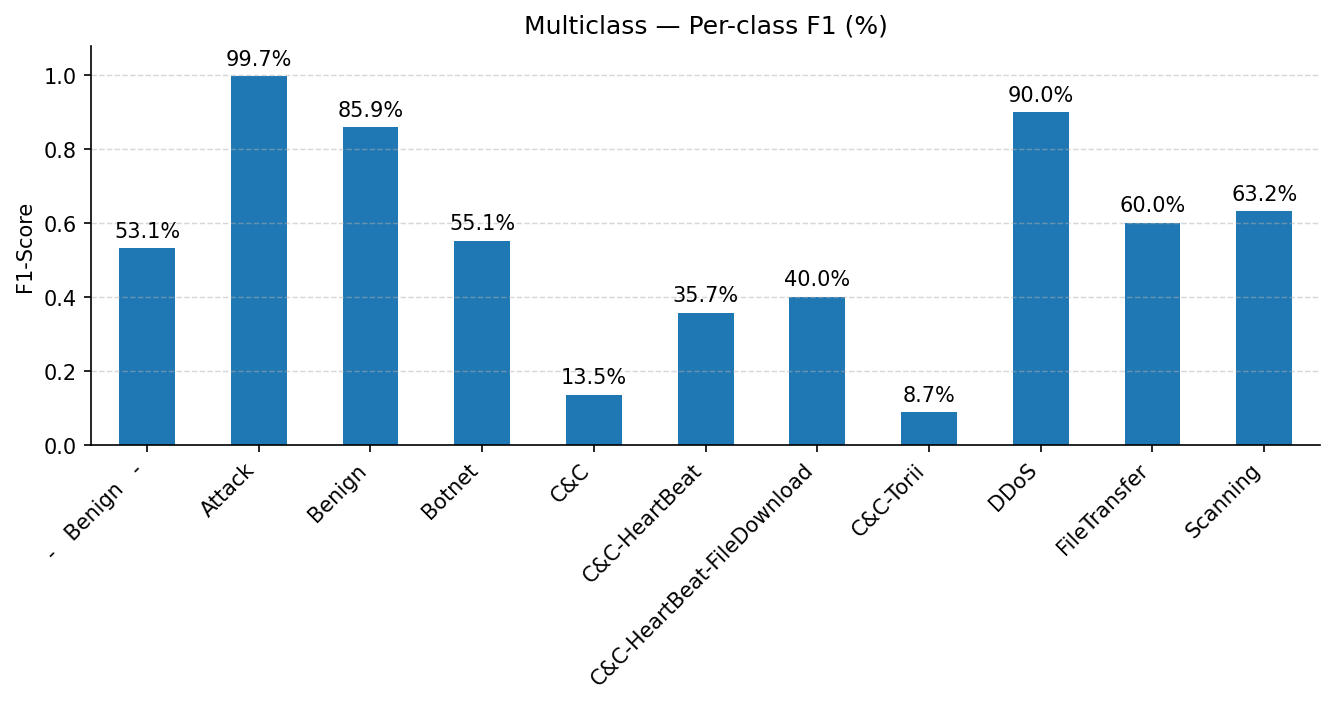

In [39]:
# Per-class Precision / Recall / F1 (robust to both CSV orientations)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rep = pd.read_csv(METRICS / f"{PREFIX_MC}_report.csv", index_col=0)

def is_avg(name: str) -> bool:
    s = str(name).lower()
    return ("avg" in s) or ("accuracy" in s)

if {"precision","recall","f1-score"}.issubset(rep.columns):
    # ORIENTATION A: rows = labels, cols = metrics
    metrics_df = rep.loc[~rep.index.map(is_avg), ["precision","recall","f1-score","support"]].copy()
else:
    # ORIENTATION B: rows = metrics, cols = labels
    want_rows = [r for r in ["precision","recall","f1-score","support"] if r in rep.index]
    tmp = rep.loc[want_rows].copy()           # rows = wanted metrics, cols = labels (incl. possibly avg cols)
    # drop any columns whose *label name* looks like an avg/accuracy
    tmp = tmp.loc[:, ~tmp.columns.map(is_avg)]
    # stack into tidy long then unstack back to labels x metrics
    metrics_df = tmp.T.copy()                 # now rows = labels, cols = wanted metrics
    if "support" not in metrics_df.columns:
        metrics_df["support"] = np.nan

# CSV
tidy_csv = METRICS / "multiclass_per_class_metrics.csv"
metrics_df.to_csv(tidy_csv)
print("[SAVED]", tidy_csv)

# Show weakest/strongest by F1 (if present)
if "f1-score" in metrics_df.columns:
    display(metrics_df.sort_values("f1-score", ascending=True).head(5))
    display(metrics_df.sort_values("f1-score", ascending=False).head(5))

# Plot per-class F1 
if "f1-score" in metrics_df.columns:
    vals = metrics_df["f1-score"].astype(float)
    plt.figure(figsize=(max(9, 0.5*len(metrics_df)), 4.8), dpi=150)
    ax = vals.plot(kind="bar")

    ax.set_ylim(0, 1.08)  # make room for labels above bars
    ax.set_ylabel("F1-Score")
    ax.set_title("Multiclass — Per-class F1 (%)")
    plt.xticks(rotation=45, ha="right")

    # styling (optional but clean)
    ax.grid(axis="y", linestyle="--", linewidth=0.7, alpha=0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # add percentage labels on top of bars
    for p in ax.patches:
        h = p.get_height()
        ax.text(
            p.get_x() + p.get_width()/2,
            h + 0.02,
            f"{h:.1%}",
            ha="center",
            va="bottom",
            fontsize=10
        )

    plt.tight_layout()
    save_fig("multiclass_f1.png")
    plt.show()
else:
    print("[INFO] 'f1-score' not found in report; skipping bar plot.")



Weak classes (lowest F1) are the ones to target for feature engineering or rebalancing

Top confusion pairs cell

In [51]:
# Build from the confusion matrix
import numpy as np, pandas as pd

cm_df = pd.read_csv(METRICS / f"{PREFIX_MC}_cm.csv", index_col=0)
labels = cm_df.index.tolist()
cm = cm_df.values

cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1)

pairs = []
for i, true_lbl in enumerate(labels):
    for j, pred_lbl in enumerate(labels):
        if i != j and cm_norm[i, j] > 0:
            pairs.append((true_lbl, pred_lbl, cm_norm[i, j], int(cm[i, j])))

pairs_sorted = sorted(pairs, key=lambda x: x[2], reverse=True)[:15]
top_confusions = pd.DataFrame(
    pairs_sorted, columns=["True", "Pred", "Rate (row-norm)", "Count"]
)

# Round nicely for viewing
top_confusions["Rate (row-norm)"] = top_confusions["Rate (row-norm)"].round(2)

# Display without .style
from IPython.display import display
display(top_confusions)

# Also save to CSV
out_csv = METRICS / "multiclass_top_confusions.csv"
top_confusions.to_csv(out_csv, index=False)
print("[SAVED]", out_csv)


,True,Pred,Rate (row-norm),Count
0,C&C-Torii,C&C,0.58,7
1,Scanning,Botnet,0.40,131514
2,- Benign -,C&C,0.40,23196
3,C&C-HeartBeat-FileDownload,C&C,0.33,1
4,C&C-HeartBeat-FileDownload,FileTransfer,0.33,1
5,C&C-HeartBeat,C&C,0.27,38
6,C&C-Torii,- Benign -,0.25,3
7,C&C,- Benign -,0.24,1463
8,- Benign -,Botnet,0.22,12917
9,C&C-HeartBeat,- Benign -,0.20,28


[SAVED] c:\PROJECT_IOT_IDS\results\metrics\multiclass_top_confusions.csv


Feature importances

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\multiclass_feature_importances.png


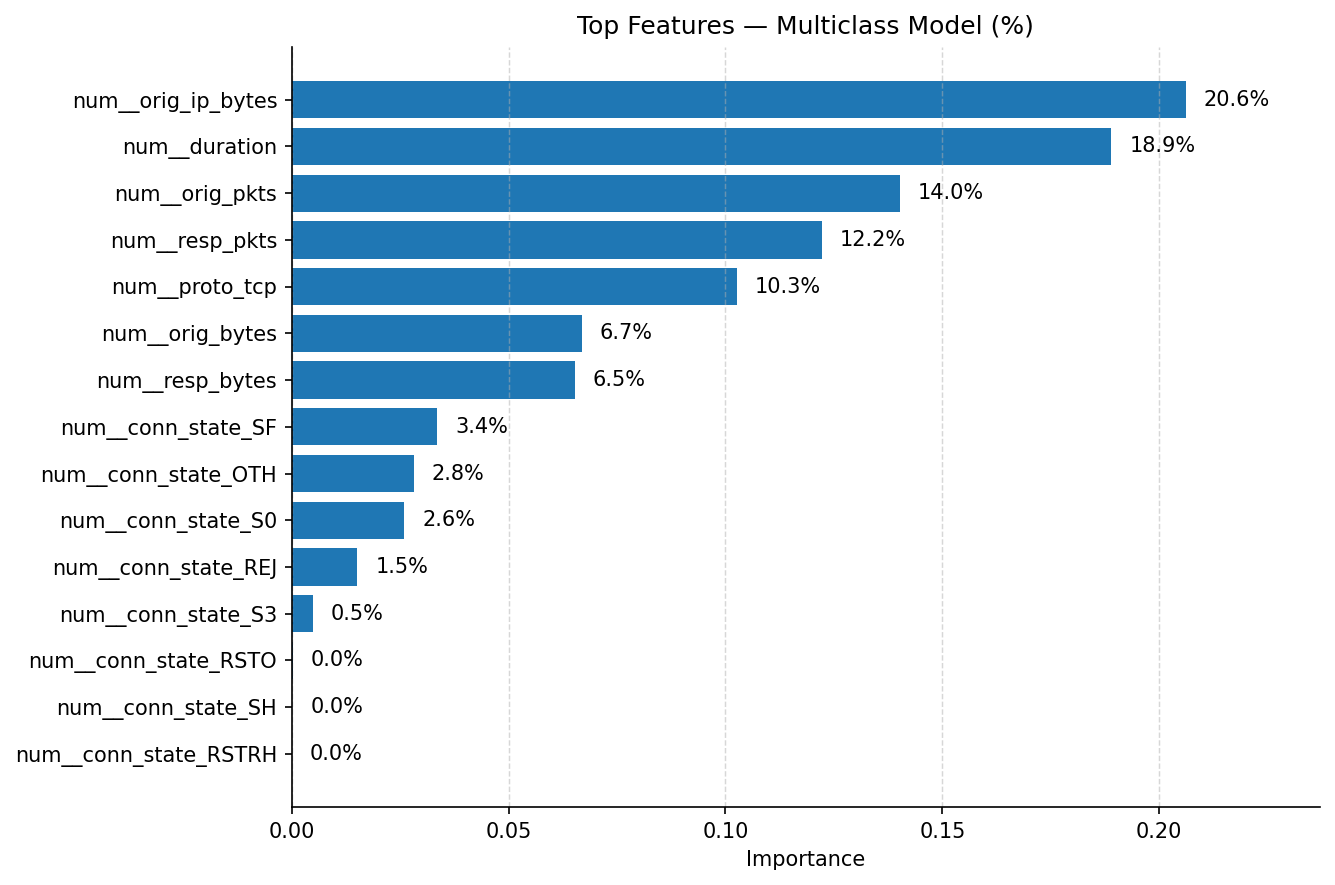

[SAVED] c:\PROJECT_IOT_IDS\results\metrics\multiclass_feature_importances_top25.csv


In [15]:
import joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt

model_path = ROOT / "results" / "models" / f"{PREFIX_MC}.joblib"

if model_path.exists():
    bundle = joblib.load(model_path)
    clf = bundle.get("classifier")
    feat_names = bundle.get("feature_names") or []

    # check for built-in feature importances
    if hasattr(clf, "feature_importances_"):
        importances = np.asarray(clf.feature_importances_).ravel()

        # robust feature names fallback if missing/mismatched
        if not feat_names or len(feat_names) != len(importances):
            feat_names = [f"f{i}" for i in range(len(importances))]

        fi = pd.Series(importances, index=feat_names).dropna()
        fi = fi.sort_values(ascending=False).head(25)  # top 25

        # PLOT: horizontal bar chart 
        fig, ax = plt.subplots(figsize=(9, max(4.8, 0.4*len(fi))), dpi=150)

        # reverse for "most important at top"
        y_labels = fi.index[::-1]
        y_vals   = fi.values[::-1]
        bars = ax.barh(y_labels, y_vals)

        ax.set_xlabel("Importance")
        ax.set_title("Top Features — Multiclass Model (%)")

        # clean styling
        ax.grid(axis="x", linestyle="--", linewidth=0.7, alpha=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # add % labels to the right of bars
        total = float(fi.sum()) if fi.sum() is not None else 0.0
        max_w = float(y_vals.max()) if len(y_vals) else 1.0
        ax.set_xlim(0, max_w * 1.15)  # room for labels

        for r in bars:
            w = r.get_width()
            ax.text(
                w + max_w*0.02,
                r.get_y() + r.get_height()/2,
                f"{(w/total):.1%}" if total > 0 else "0.0%",
                va="center", ha="left", fontsize=10
            )

        plt.tight_layout()
        save_fig("multiclass_feature_importances.png")
        plt.show()
    

        # also save to CSV (raw importance values, unchanged)
        fi.to_frame("importance").to_csv(METRICS / "multiclass_feature_importances_top25.csv")
        print("[SAVED]", METRICS / "multiclass_feature_importances_top25.csv")

    else:
        print("[INFO] Classifier has no 'feature_importances_' (e.g., linear model or tree-free). Skipping plot.")
else:
    print("[SKIP] Model bundle not found:", model_path)


Semi-supervised curve

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\semi_curve.png


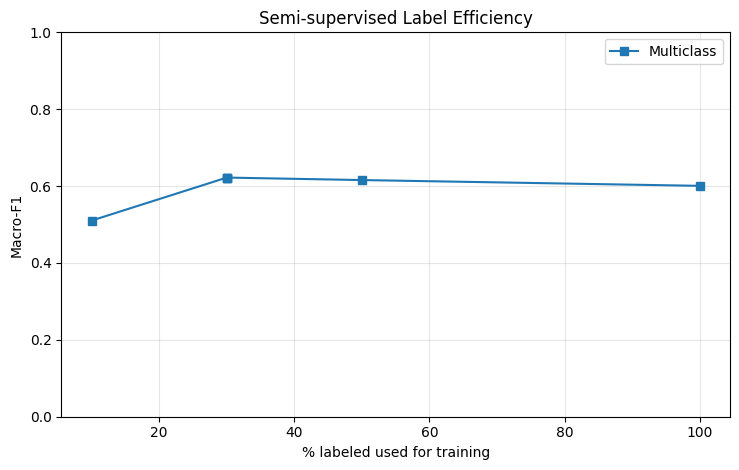

In [53]:
csv_path = METRICS / "semi_supervised_curve.csv"
df = pd.read_csv(csv_path)

# Expect columns: target, label_frac, macro_f1, precision, recall, n_pseudo
df = df.sort_values(["target","label_frac"])
df_bin  = df[df["target"].astype(str).str.contains("binary", case=False, na=False)]
df_mc   = df[df["target"].astype(str).str.contains("multi",  case=False, na=False)]

plt.figure(figsize=(7.5,4.8))
if not df_bin.empty:
    plt.plot(df_bin["label_frac"]*100, df_bin["macro_f1"], marker="o", label="Binary")
if not df_mc.empty:
    plt.plot(df_mc["label_frac"]*100, df_mc["macro_f1"], marker="s", label="Multiclass")
plt.xlabel("% labeled used for training")
plt.ylabel("Macro-F1")
plt.title("Semi-supervised Label Efficiency")
plt.ylim(0,1); plt.grid(alpha=0.3); plt.legend()
save_fig("semi_curve.png")
plt.show()


Shows how performance scales as you keep more labels.

If curves rise sharply at small % labeled, your semi-supervised step is effective. Plateaus indicate diminishing returns.

Label efficiency (multiclass)

[SAVED] C:\PROJECT_IOT_IDS\results\figures\viz\label_efficiency_multiclass.png


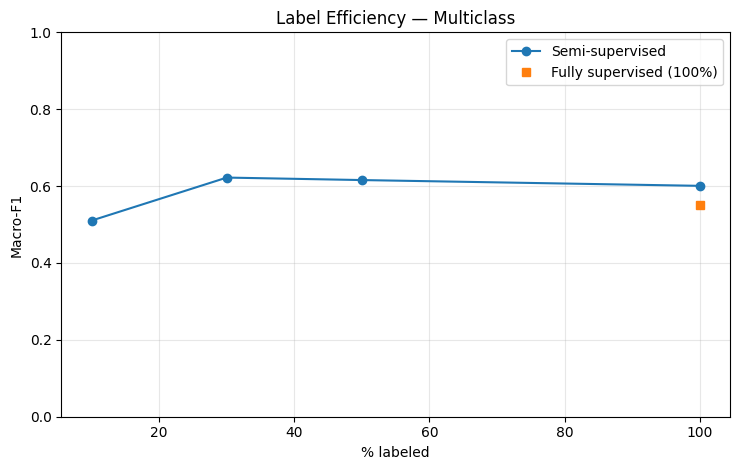

In [13]:
df = pd.read_csv(METRICS / "label_efficiency_multiclass.csv")

plt.figure(figsize=(7.5,4.8))
semi_df = df[df["series"]=="semi"].sort_values("pct")
plt.plot(semi_df["pct"], semi_df["macro_f1"], marker="o", label="Semi-supervised")

sup_df = df[df["series"]=="supervised"]
if not sup_df["macro_f1"].isna().all():
    plt.plot(sup_df["pct"], sup_df["macro_f1"], marker="s", linestyle="None", label="Fully supervised (100%)")

plt.xlabel("% labeled"); plt.ylabel("Macro-F1"); plt.ylim(0,1)
plt.title("Label Efficiency — Multiclass")
plt.grid(alpha=0.3); plt.legend()
save_fig("label_efficiency_multiclass.png")
plt.show()


Hybrid LOFO — Detection on unseen family

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\hybrid_lofo_detection.png


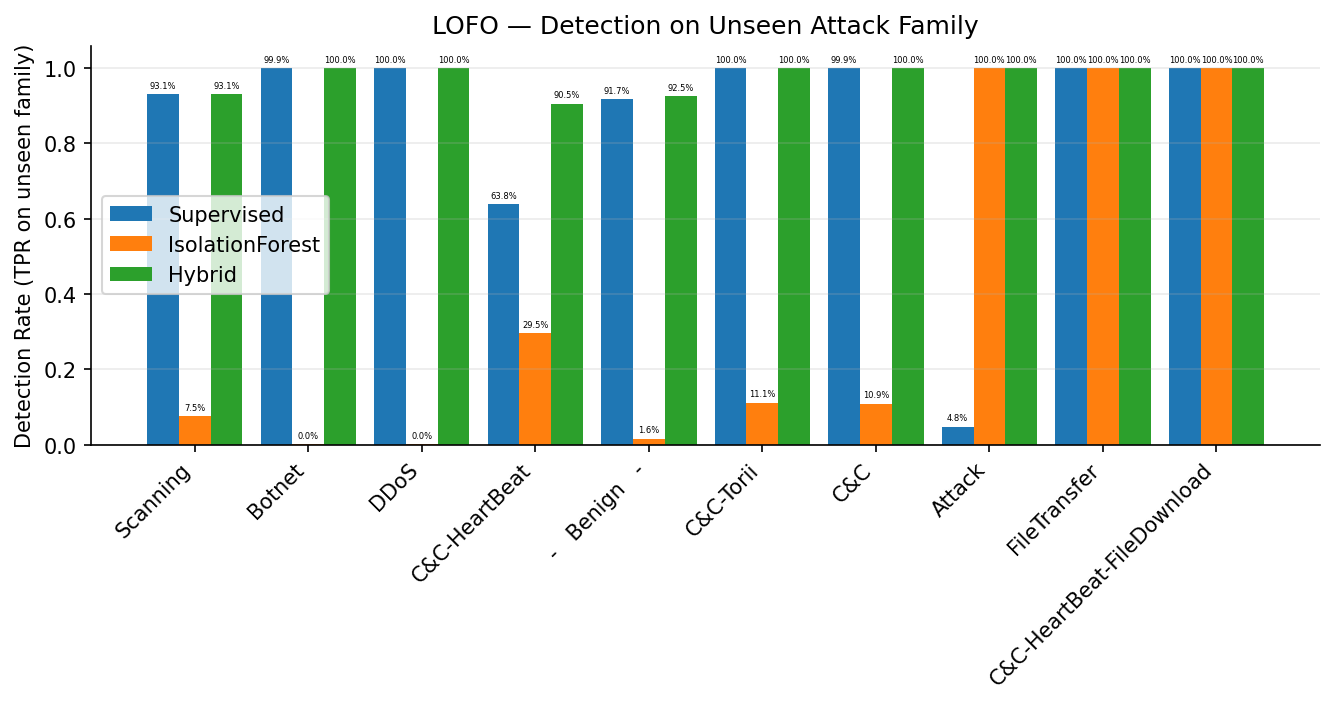

In [24]:
lofo = pd.read_csv(METRICS / "hybrid_lofo_summary.csv")
families = lofo["family"].tolist()
x = np.arange(len(families)); w = 0.28

fig, ax = plt.subplots(figsize=(max(9, 0.6*len(families)), 4.8), dpi=150)

b1 = ax.bar(x - w, lofo["sup_det_rate_on_F"],      width=w, label="Supervised")
b2 = ax.bar(x,      lofo["iforest_det_rate_on_F"],  width=w, label="IsolationForest")
b3 = ax.bar(x + w,  lofo["hybrid_det_rate_on_F"],   width=w, label="Hybrid")

ax.set_xticks(x)
ax.set_xticklabels(families, rotation=45, ha="right")
ax.set_ylabel("Detection Rate (TPR on unseen family)")
ax.set_title("LOFO — Detection on Unseen Attack Family")

# slightly less headroom since labels are smaller
ax.set_ylim(0, 1.06)

ax.legend()
ax.grid(axis="y", alpha=0.25)
for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

# --- smaller % labels on top of each bar ---
def add_pct_labels(bars, dy=0.012, fmt="{:.1%}", fontsize=4):
    for r in bars:
        h = r.get_height()
        ax.text(
            r.get_x() + r.get_width()/2,
            h + dy,
            fmt.format(h),
            ha="center", va="bottom",
            fontsize=fontsize,
            clip_on=True
        )

add_pct_labels(b1); add_pct_labels(b2); add_pct_labels(b3)
# -------------------------------------------

plt.tight_layout()
save_fig("hybrid_lofo_detection.png")
plt.show()


“Hybrid” (supervised ∪ anomaly) should lift zero-day detection beyond supervised-only.

Identify particularly hard families (low TPR) for targeted improvements.

Hybrid LOFO — Benign false-positive rate

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\hybrid_lofo_benign_fpr.png


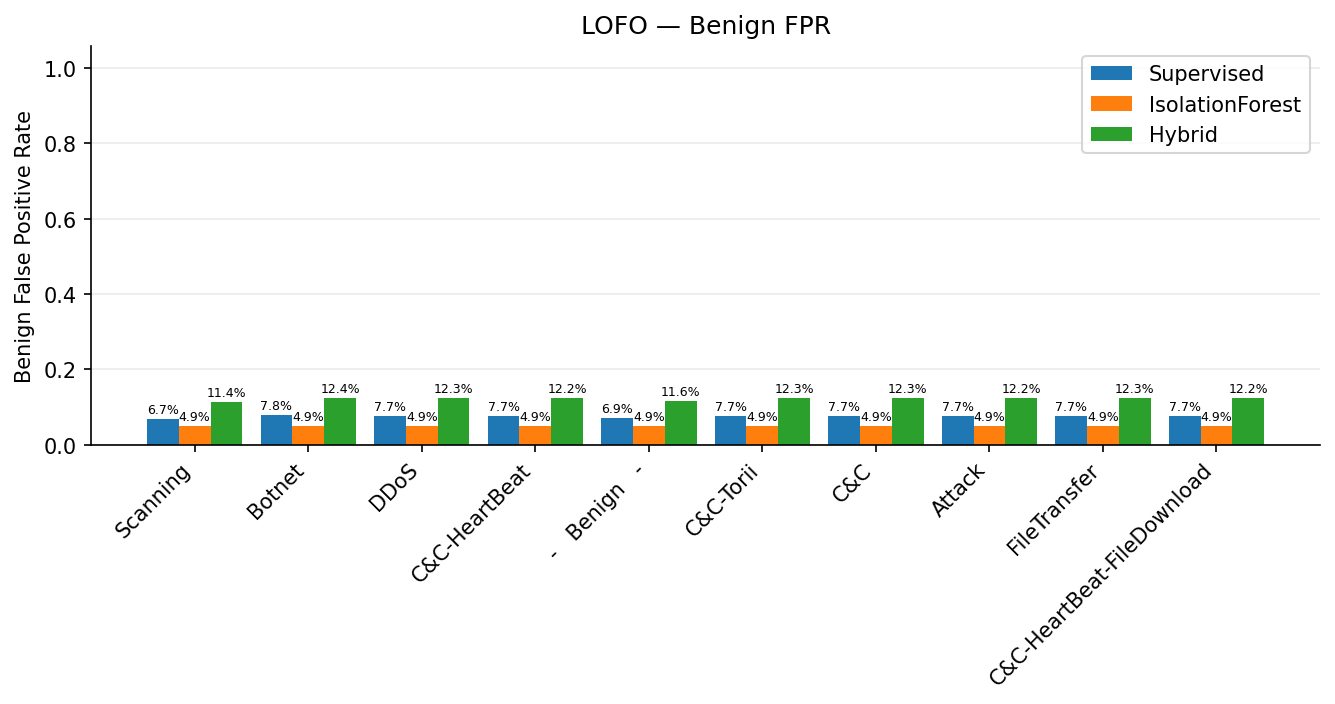

In [ ]:
lofo = pd.read_csv(METRICS / "hybrid_lofo_summary.csv")
families = lofo["family"].tolist()
x = np.arange(len(families)); w = 0.28

fig, ax = plt.subplots(figsize=(max(9, 0.6*len(families)), 4.8), dpi=150)

b1 = ax.bar(x - w, lofo["benign_fpr_sup"].astype(float),     width=w, label="Supervised")
b2 = ax.bar(x,      lofo["benign_fpr_iforest"].astype(float), width=w, label="IsolationForest")
b3 = ax.bar(x + w,  lofo["benign_fpr_hybrid"].astype(float),  width=w, label="Hybrid")

ax.set_xticks(x)
ax.set_xticklabels(families, rotation=45, ha="right")
ax.set_ylabel("Benign False Positive Rate")
ax.set_title("LOFO — Benign FPR")

ax.set_ylim(0, 1.06)

ax.legend()
ax.grid(axis="y", alpha=0.25)
for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

def add_pct_labels(bars, dy=0.008, fmt="{:.1%}", fontsize=6):
    for r in bars:
        h = r.get_height()
        ax.text(
            r.get_x() + r.get_width()/2,
            h + dy,
            fmt.format(max(h, 0.0)),
            ha="center", va="bottom",
            fontsize=fontsize,
            clip_on=True
        )

add_pct_labels(b1, fontsize=6)
add_pct_labels(b2, fontsize=6)
add_pct_labels(b3, fontsize=6)

plt.tight_layout()
save_fig("hybrid_lofo_benign_fpr.png")
plt.show()


Check the cost of hybrid gains. If FPR rises too much, tune the anomaly threshold τ or require consensus.

concept srift setup

In [7]:

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


ROOT = Path(r"C:\PROJECT_IOT_IDS")

METRICS = ROOT / "results" / "metrics"
VIZ     = ROOT / "results" / "figures" / "viz"
VIZ.mkdir(parents=True, exist_ok=True)

def save_fig(name, dpi=160):
    out = VIZ / name
    plt.tight_layout()
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    print("[SAVED]", out)


In [8]:
# upload CSV
files = {
    "Supervised": METRICS / "drift_timeline.csv",             # from train_concept_drift.py
    "Semi-supervised": METRICS / "drift_timeline_semi.csv",   # from train_concept_drift_semi.py
    "Hybrid": METRICS / "drift_timeline_hybrid.csv",          # from train_concept_drift_hybrid.py
}

dfs = {}
for label, path in files.items():
    if path.exists():
        df = pd.read_csv(path).sort_values("step")
        df["series"] = label
        dfs[label] = df
        print(f"[OK] {label}: {path}")
    else:
        print(f"[MISS] {label}: {path} (not found)")

if not dfs:
    raise SystemExit("No drift timeline files found. Check ROOT or file names.")


[OK] Supervised: C:\PROJECT_IOT_IDS\results\metrics\drift_timeline.csv
[OK] Semi-supervised: C:\PROJECT_IOT_IDS\results\metrics\drift_timeline_semi.csv
[OK] Hybrid: C:\PROJECT_IOT_IDS\results\metrics\drift_timeline_hybrid.csv


supervised

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\drift_timeline.png


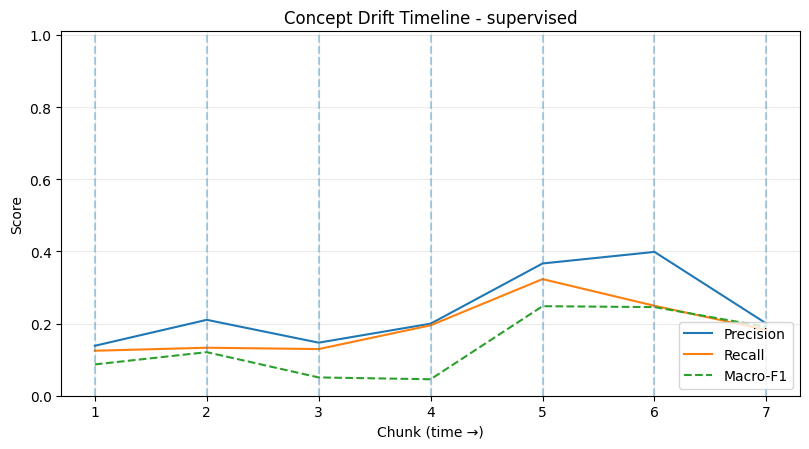

In [26]:
tl = pd.read_csv(METRICS / "drift_timeline.csv")

plt.figure(figsize=(8.2,4.6))
win = max(1, min(5, int(len(tl)*0.1)))  # light smoothing
if "precision" in tl.columns:
    plt.plot(tl["step"], tl["precision"].rolling(win, min_periods=1).mean(), label="Precision")
if "recall" in tl.columns:
    plt.plot(tl["step"], tl["recall"].rolling(win, min_periods=1).mean(), label="Recall")
plt.plot(tl["step"], tl["macro_f1"].rolling(win, min_periods=1).mean(), linestyle="--", label="Macro-F1")

if "drift_flag" in tl.columns:
    for s in tl.loc[tl["drift_flag"]==1, "step"]:
        plt.axvline(s, linestyle="--", alpha=0.35)

plt.xlabel("Chunk (time →)")
plt.ylabel("Score"); plt.ylim(0,1.01)
plt.title("Concept Drift Timeline - supervised")
plt.legend(loc="lower right"); plt.grid(alpha=0.25)
save_fig("drift_timeline.png")
plt.show()

semi supervised

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\drift_timeline_semi.png


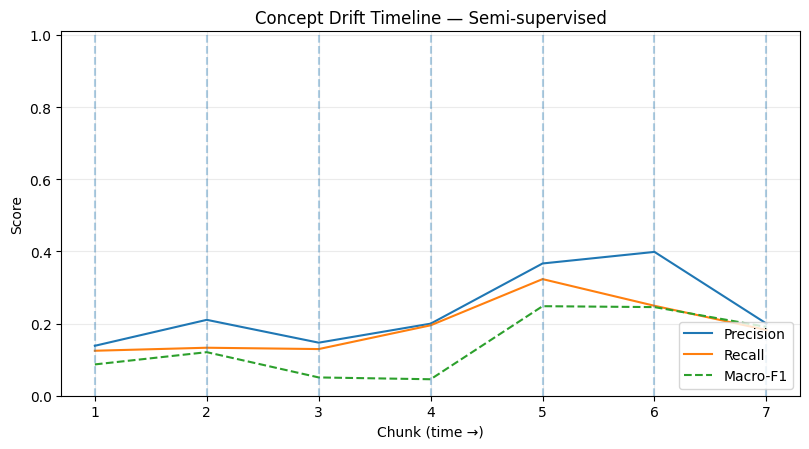

In [27]:
# Semi-supervised Drift Timeline
tl_semi = pd.read_csv(METRICS / "drift_timeline_semi.csv")

plt.figure(figsize=(8.2,4.6))
win = max(1, min(5, int(len(tl_semi)*0.1)))
if "precision" in tl_semi.columns:
    plt.plot(tl_semi["step"], tl_semi["precision"].rolling(win, min_periods=1).mean(), label="Precision")
if "recall" in tl_semi.columns:
    plt.plot(tl_semi["step"], tl_semi["recall"].rolling(win, min_periods=1).mean(), label="Recall")
plt.plot(tl_semi["step"], tl_semi["macro_f1"].rolling(win, min_periods=1).mean(), linestyle="--", label="Macro-F1")

if "drift_flag" in tl_semi.columns:
    for s in tl_semi.loc[tl_semi["drift_flag"]==1, "step"]:
        plt.axvline(s, linestyle="--", alpha=0.35)

plt.xlabel("Chunk (time →)")
plt.ylabel("Score"); plt.ylim(0,1.01)
plt.title("Concept Drift Timeline — Semi-supervised")
plt.legend(loc="lower right"); plt.grid(alpha=0.25)
save_fig("drift_timeline_semi.png")
plt.show()

hybrid

[SAVED] c:\PROJECT_IOT_IDS\results\figures\viz\drift_timeline_hybrid.png


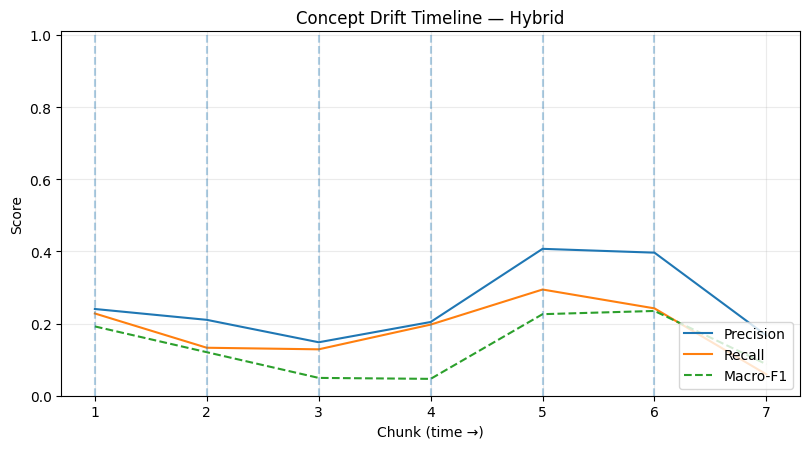

In [28]:
# Hybrid Drift Timeline
tl_hyb = pd.read_csv(METRICS / "drift_timeline_hybrid.csv")

plt.figure(figsize=(8.2,4.6))
win = max(1, min(5, int(len(tl_hyb)*0.1)))
if "precision" in tl_hyb.columns:
    plt.plot(tl_hyb["step"], tl_hyb["precision"].rolling(win, min_periods=1).mean(), label="Precision")
if "recall" in tl_hyb.columns:
    plt.plot(tl_hyb["step"], tl_hyb["recall"].rolling(win, min_periods=1).mean(), label="Recall")
plt.plot(tl_hyb["step"], tl_hyb["macro_f1"].rolling(win, min_periods=1).mean(), linestyle="--", label="Macro-F1")

if "drift_flag" in tl_hyb.columns:
    for s in tl_hyb.loc[tl_hyb["drift_flag"]==1, "step"]:
        plt.axvline(s, linestyle="--", alpha=0.35)

plt.xlabel("Chunk (time →)")
plt.ylabel("Score"); plt.ylim(0,1.01)
plt.title("Concept Drift Timeline — Hybrid")
plt.legend(loc="lower right"); plt.grid(alpha=0.25)
save_fig("drift_timeline_hybrid.png")
plt.show()

real time simulation

[INFO] Columns: ['chunk', 'rows', 'accuracy', 'n_attacks', 'n_predicted_attacks', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1', 'alert_rate', 'attack_rate', 'top_attack_label', 'top_attack_count', 'top3_attack_labels', 'top_scenario', 'top_scenario_count']


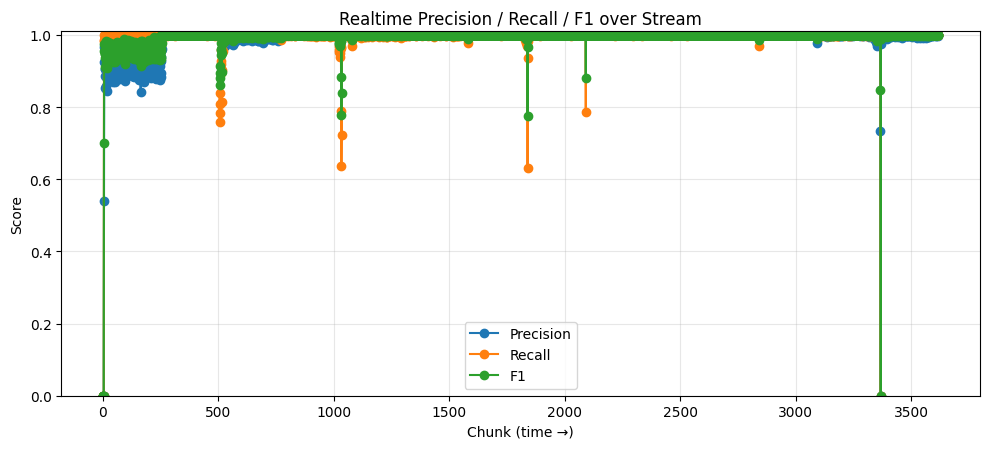

[SAVED] C:\PROJECT_IOT_IDS\results\figures\viz\realtime_prf_timeline.png


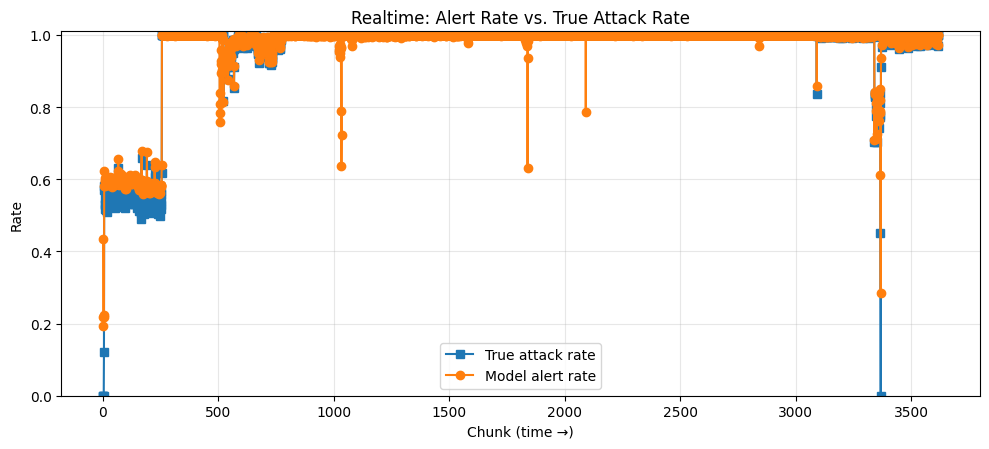

[SAVED] C:\PROJECT_IOT_IDS\results\figures\viz\realtime_alert_vs_attack_rate.png


,chunk,rows,accuracy,precision,recall,f1,n_attacks,n_predicted_attacks,attack_rate,alert_rate,top_attack_label,top_attack_count,top_scenario,top_scenario_count
3616,3617,221,1.0,1.0,1.0,1.0,221,221,1.0,1.0,Scanning,221,NaN,0
3598,3599,400,1.0,1.0,1.0,1.0,400,400,1.0,1.0,Scanning,400,NaN,0
3597,3598,400,1.0,1.0,1.0,1.0,400,400,1.0,1.0,Scanning,400,NaN,0
3593,3594,400,1.0,1.0,1.0,1.0,400,400,1.0,1.0,Scanning,400,NaN,0
3590,3591,400,1.0,1.0,1.0,1.0,400,400,1.0,1.0,Scanning,400,NaN,0


[SAVED] C:\PROJECT_IOT_IDS\results\figures\viz\realtime_top_anomalous_chunks_with_context.csv

[Caption]
Figure : Realtime precision/recall/F1 over streaming chunks. Higher and stable values indicate reliable online detection; dips typically align with attack bursts or distributional shifts.
Figure Y: Alert rate vs. true attack rate. Good behavior is when the alert rate tracks peaks in the true attack rate while remaining low during benign periods, indicating timely detection with controlled false alarms.
Table Z: Top-5 anomalous chunks ranked by alert rate, with dominant attack label/scenario per chunk; these provide interpretable context for the detected bursts.


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("C:/PROJECT_IOT_IDS")
METRICS = ROOT / "results" / "metrics"
VIZ = ROOT / "results" / "figures" / "viz"
VIZ.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(METRICS / "realtime_stream_results.csv")
print("[INFO] Columns:", df.columns.tolist())

# 1) Precision / Recall / F1 timeline
plt.figure(figsize=(10,4.6))
for col in ["precision","recall","f1"]:
    if col in df.columns:
        plt.plot(df["chunk"], df[col], marker="o", label=col.capitalize())
plt.ylim(0,1.01); plt.grid(alpha=0.3)
plt.xlabel("Chunk (time →)"); plt.ylabel("Score")
plt.title("Realtime Precision / Recall / F1 over Stream")
plt.legend()
out1 = VIZ / "realtime_prf_timeline.png"
plt.tight_layout(); plt.savefig(out1, dpi=160, bbox_inches="tight"); plt.show()
print("[SAVED]", out1)

# 2) Alert vs Attack rate
if {"alert_rate","attack_rate"}.issubset(df.columns):
    plt.figure(figsize=(10,4.6))
    plt.plot(df["chunk"], df["attack_rate"], marker="s", label="True attack rate")
    plt.plot(df["chunk"], df["alert_rate"],  marker="o", label="Model alert rate")
    plt.ylim(0,1.01); plt.grid(alpha=0.3)
    plt.xlabel("Chunk (time →)"); plt.ylabel("Rate")
    plt.title("Realtime: Alert Rate vs. True Attack Rate")
    plt.legend()
    out2 = VIZ / "realtime_alert_vs_attack_rate.png"
    plt.tight_layout(); plt.savefig(out2, dpi=160, bbox_inches="tight"); plt.show()
    print("[SAVED]", out2)

# 3) Top anomalous chunks table with context
topN = df.sort_values("alert_rate", ascending=False).head(5).copy()
keep_cols = [c for c in [
    "chunk","rows","accuracy","precision","recall","f1",
    "n_attacks","n_predicted_attacks","attack_rate","alert_rate",
    "top_attack_label","top_attack_count","top_scenario","top_scenario_count"
] if c in df.columns]
topN = topN[keep_cols].round(4)
display(topN)

csv_out = VIZ / "realtime_top_anomalous_chunks_with_context.csv"
topN.to_csv(csv_out, index=False)
print("[SAVED]", csv_out)

# 4) Paper caption (copy-paste)
print("\n[Caption]")
print("Figure : Realtime precision/recall/F1 over streaming chunks. Higher and stable values indicate reliable online detection; dips typically align with attack bursts or distributional shifts.")
print("Figure Y: Alert rate vs. true attack rate. Good behavior is when the alert rate tracks peaks in the true attack rate while remaining low during benign periods, indicating timely detection with controlled false alarms.")
print("Table Z: Top-5 anomalous chunks ranked by alert rate, with dominant attack label/scenario per chunk; these provide interpretable context for the detected bursts.")
